In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.text import Tokenizer
from konlpy.tag import Okt
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
import re

Using TensorFlow backend.


# 데이터 불러오기
- FastText
- 네이버 영화 리뷰

In [2]:
from gensim import models

#https://fasttext.cc/docs/en/crawl-vectors.html , Fasttext 한국어 모델 파일 다운로드
ko_model = models.fasttext.load_facebook_model('wiki.ko.bin')

In [3]:
# 네이버 영화 리뷰 불러오기
df = pd.read_excel('ratings_train.xlsx')

# 영화리뷰와 라벨 분리
doc = list(df['document'])
labels = list(df['label'])

# 영화 리뷰 전처리 X
- 전처리를 하지 않고 한글만 추출

In [4]:
unprocessed = []
for sentence in doc:
    try:
        unprocessed.append(re.findall('[가-힣]+', sentence))
    except:
        unprocessed.append('아')

In [5]:
unprocessed[:10]

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나'],
 ['너무재밓었다그래서보는것을추천한다'],
 ['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정'],
 ['사이몬페그의',
  '익살스런',
  '연기가',
  '돋보였던',
  '영화',
  '스파이더맨에서',
  '늙어보이기만',
  '했던',
  '커스틴',
  '던스트가',
  '너무나도',
  '이뻐보였다'],
 ['막', '걸음마', '뗀', '세부터', '초등학교', '학년생인', '살용영화', '별반개도', '아까움'],
 ['원작의', '긴장감을', '제대로', '살려내지못했다'],
 ['별',
  '반개도',
  '아깝다',
  '욕나온다',
  '이응경',
  '길용우',
  '연기생활이몇년인지',
  '정말',
  '발로해도',
  '그것보단',
  '낫겟다',
  '납치',
  '감금만반복반복',
  '이드라마는',
  '가족도없다',
  '연기못하는사람만모엿네'],
 ['액션이', '없는데도', '재미', '있는', '몇안되는', '영화'],
 ['왜케', '평점이', '낮은건데', '꽤', '볼만한데', '헐리우드식', '화려함에만', '너무', '길들여져', '있나']]

# 영화 리뷰 전처리
- 어간 추출 & 조사, 어미, 구두점 제외
- 불용어처리

In [4]:
okt = Okt()

In [5]:
clean_doc = []
error_list = []
for i, document in enumerate(doc):
    clean_words = []
    try:
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] not in ['Josa', 'Eomi', 'Punctuation']: #조사, 어미, 구두점 제외 
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        clean_doc.append(document)
    except:
        #결측치를 '아'로 처리
      clean_doc.append('아')
      error_list.append(document)
      

In [6]:
print('결측치 개수: ',len(error_list))
print('결측치 예시: ', error_list[:10])

결측치 개수:  115
결측치 예시:  [1, 4, 4, 1236547890, 1, nan, 3.6, nan, 2.6, 1]


In [7]:
nltk.download('punkt')
stopwords = ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하']

for i, document in enumerate(clean_doc):
    clean_words = [] 
    for word in nltk.tokenize.word_tokenize(document): 
        if word not in stopwords: #불용어 제거
            clean_words.append(word)   
    clean_doc[i] = ' '.join(clean_words)        

clean_doc[:10]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['아 더빙 진짜 짜증나다 목소리',
 '흠 포스터 보고 초딩 영화 줄 오버 연기 가볍다 않다',
 '너 무재 밓었 다그 래서 보다 추천 다',
 '교도소 이야기 구먼 솔직하다 재미 없다 평점 조정',
 '사이 몬페 의 익살스럽다 연기 돋보이다 영화 스파이더맨 늙다 보이다 하다 커스틴 던스트 너무나도 이쁘다 보이다',
 '막 걸음 마 떼다 3 세 초등학교 1 학년 생인 8 살다 영화 ㅋㅋㅋ 별 반개 아깝다 움',
 '원작 긴장감 제대로 살리다 하다',
 '별 반개 아깝다 욕 나오다 이응경 길용우 연 기 생활 몇 정말 발 해도 그것 낫다 납치 감금 반복 반복 드라마 가족 없다 연기 못 하다 모 엿 네',
 '액션 없다 재미 있다 몇 안되다 영화',
 '왜케 평점 낮다 꽤 볼 데 헐리우드 식 화려하다 너무 길들이다 있다']

# 토크나이즈 (전처리 X)

문장의 최대 길이: 47 임베딩 매트릭스 형태:  (278263, 300)


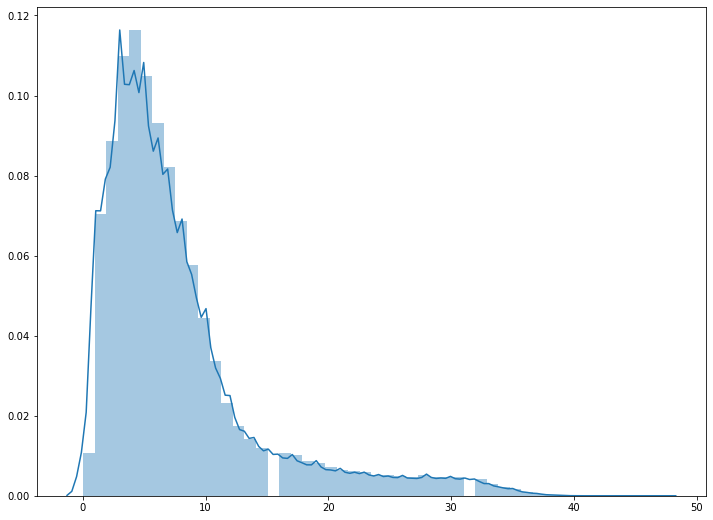

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(unprocessed)
vocab_size = len(tokenizer.word_index) + 1

X_encoded = tokenizer.texts_to_sequences(unprocessed)
max_len = max(len(I) for I in X_encoded)

# 단어의 길이 빈도수 확인
count_len = pd.Series(X_encoded).apply(len)

plt.figure(figsize=(12,9))
sns.distplot(count_len)

#빈도수를 평준화하기 위해서 max_len 값을 조절

X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(labels)

import numpy as np

VOCAB_SIZE = len(tokenizer.index_word) + 1 #1을 더해주는 것은 0으로 채운 padding 때문
EMBEDDING_DIM = 300 #Fasttext의 embedding_dimension = 300

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    embedding_vector = ko_model.wv.word_vec(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
print('문장의 최대 길이:', max_len , '임베딩 매트릭스 형태: ', embedding_matrix.shape)

In [8]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
non_pre_model = tf.keras.Model(sequence_input, output)
non_pre_model.summary()

NameError: name 'max_len' is not defined

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

non_pre_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

non_pre_history = non_pre_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 65s 17ms/step - loss: 0.6914 - accuracy: 0.5752 - val_loss: 0.6478 - val_accuracy: 0.6418
Epoch 2/10
3750/3750 [==============================] - 67s 18ms/step - loss: 0.6360 - accuracy: 0.6688 - val_loss: 0.6049 - val_accuracy: 0.7000
Epoch 3/10
3750/3750 [==============================] - 67s 18ms/step - loss: 0.5950 - accuracy: 0.7218 - val_loss: 0.5844 - val_accuracy: 0.7250
Epoch 4/10
3750/3750 [==============================] - 67s 18ms/step - loss: 0.5561 - accuracy: 0.7666 - val_loss: 0.5769 - val_accuracy: 0.7359
Epoch 5/10
3750/3750 [==============================] - 66s 18ms/step - loss: 0.5167 - accuracy: 0.8032 - val_loss: 0.5962 - val_accuracy: 0.7344
Epoch 6/10
3750/3750 [==============================] - 67s 18ms/step - loss: 0.4773 - accuracy: 0.8343 - val_loss: 0.6153 - val_accuracy: 0.7337
Epoch 7/10
3750/3750 [==============================] - 67s 18ms/step - loss: 0.4385 - accuracy: 0.8617 - val_loss: 0.6428 -

# 토크나이즈 (전처리 O)

# 레이어 생성

## 최대 길이 지정 X

문장의 최대 길이:67
임베딩 매트릭스 형태:(47192, 300) 


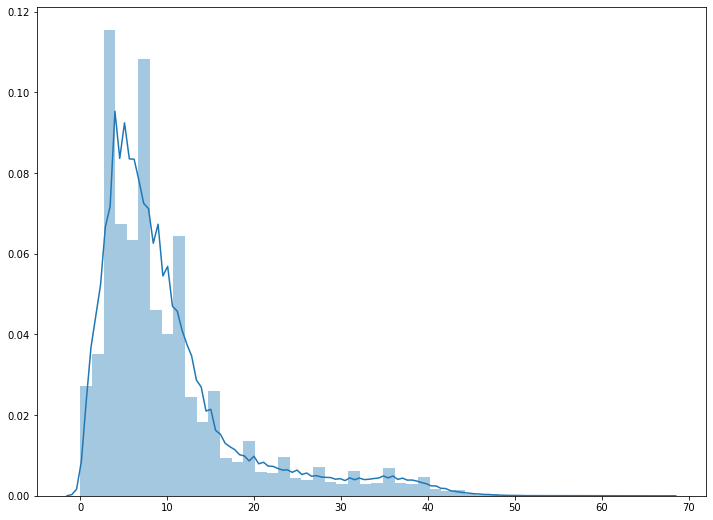

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_doc)
vocab_size = len(tokenizer.word_index) + 1

X_encoded = tokenizer.texts_to_sequences(clean_doc)
max_len = max(len(I) for I in X_encoded)

# 단어의 최대 길이 확인
count_len = pd.Series(X_encoded).apply(len)
plt.figure(figsize=(12,9))
sns.distplot(count_len)

#빈도수를 평준화하기 위해서 max_len 값을 조절

X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(labels)

import numpy as np

VOCAB_SIZE = len(tokenizer.index_word) + 1 #1을 더해주는 것은 0으로 채운 padding 때문
EMBEDDING_DIM = 300 #Fasttext의 embedding_dimension = 300

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    embedding_vector = ko_model.wv.word_vec(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
print('문장의 최대 길이:{}'.format(max_len),'임베딩 매트릭스 형태:{} '.format(embedding_matrix.shape), sep='\n')

In [10]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
max_len_max_model = tf.keras.Model(sequence_input, output)
max_len_max_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 67, 300)      14157600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 67, 128)      115328      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 67, 128)      153728      embedding[0][0]                  
_______________________________________________________________________________________

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

max_len_max_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

max_len_max_history = max_len_max_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 101s 27ms/step - loss: 0.5987 - accuracy: 0.7350 - val_loss: 0.5382 - val_accuracy: 0.7863
Epoch 2/10
3750/3750 [==============================] - 99s 26ms/step - loss: 0.5307 - accuracy: 0.8037 - val_loss: 0.5343 - val_accuracy: 0.8015
Epoch 3/10
3750/3750 [==============================] - 100s 27ms/step - loss: 0.5046 - accuracy: 0.8351 - val_loss: 0.5421 - val_accuracy: 0.8190
Epoch 4/10
3750/3750 [==============================] - 100s 27ms/step - loss: 0.4885 - accuracy: 0.8561 - val_loss: 0.5446 - val_accuracy: 0.8239
Epoch 5/10
3750/3750 [==============================] - 113s 30ms/step - loss: 0.4728 - accuracy: 0.8757 - val_loss: 0.5674 - val_accuracy: 0.8228
Epoch 6/10
3750/3750 [==============================] - 183s 49ms/step - loss: 0.4569 - accuracy: 0.8944 - val_loss: 0.6313 - val_accuracy: 0.8180
Epoch 7/10
3750/3750 [==============================] - 184s 49ms/step - loss: 0.4380 - accuracy: 0.9103 - val_loss: 0.

## 최대 길이 50

문장의 최대 길이:50
임베딩 매트릭스 형태:(47192, 300) 


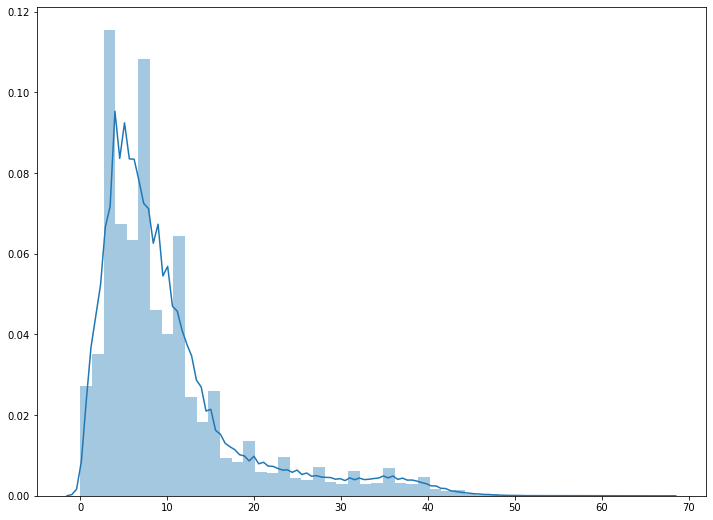

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_doc)
vocab_size = len(tokenizer.word_index) + 1

X_encoded = tokenizer.texts_to_sequences(clean_doc)
max_len = 50
# max_len = max(len(I) for I in X_encoded)

# 단어의 길이 빈도수 확인
count_len = pd.Series(X_encoded).apply(len)
plt.figure(figsize=(12,9))
sns.distplot(count_len)

#빈도수를 평준화하기 위해서 max_len 값을 조절

X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(labels)

import numpy as np

VOCAB_SIZE = len(tokenizer.index_word) + 1 #1을 더해주는 것은 0으로 채운 padding 때문
EMBEDDING_DIM = 300 #Fasttext의 embedding_dimension = 300

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    embedding_vector = ko_model.wv.word_vec(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
print('문장의 최대 길이:{}'.format(max_len),'임베딩 매트릭스 형태:{} '.format(embedding_matrix.shape), sep='\n')

In [22]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
max_len_fifty_model = tf.keras.Model(sequence_input, output)
max_len_fifty_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 300)      14157600    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 50, 128)      115328      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 50, 128)      153728      embedding_3[0][0]                
_______________________________________________________________________________________

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

max_len_fifty_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

max_len_fifty_history = max_len_fifty_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 68s 18ms/step - loss: 0.5933 - accuracy: 0.7350 - val_loss: 0.5219 - val_accuracy: 0.7873
Epoch 2/10
3750/3750 [==============================] - 69s 18ms/step - loss: 0.5200 - accuracy: 0.8028 - val_loss: 0.5086 - val_accuracy: 0.8134
Epoch 3/10
3750/3750 [==============================] - 69s 18ms/step - loss: 0.4905 - accuracy: 0.8372 - val_loss: 0.5065 - val_accuracy: 0.8278
Epoch 4/10
3750/3750 [==============================] - 68s 18ms/step - loss: 0.4703 - accuracy: 0.8593 - val_loss: 0.5333 - val_accuracy: 0.8279
Epoch 5/10
3750/3750 [==============================] - 68s 18ms/step - loss: 0.4487 - accuracy: 0.8801 - val_loss: 0.5267 - val_accuracy: 0.8304
Epoch 6/10
3750/3750 [==============================] - 69s 18ms/step - loss: 0.4263 - accuracy: 0.8999 - val_loss: 0.5673 - val_accuracy: 0.8333
Epoch 7/10
3750/3750 [==============================] - 68s 18ms/step - loss: 0.4056 - accuracy: 0.9159 - val_loss: 0.6069 -

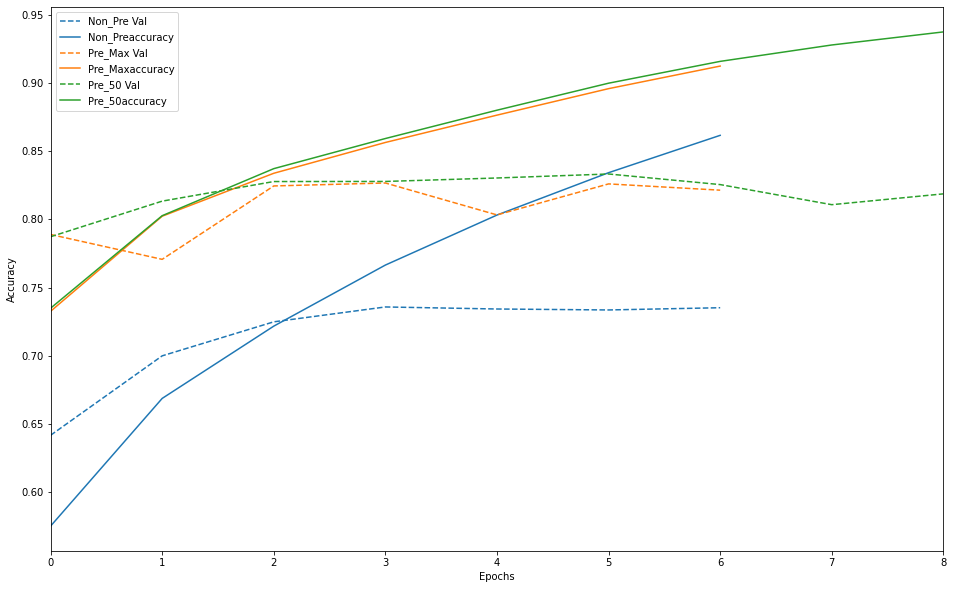

In [33]:
def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+ key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+ key)

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
    
    
plot_history([('Non_pre', non_pre_history),
              ('Pre_Max', max_len_max_history),
              ('Pre_50', max_len_fifty_history)])


# L2 규제 변경

### l2 0.2

In [24]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
l2_0_2_model = tf.keras.Model(sequence_input, output)
l2_0_2_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 300)      14157600    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 50, 128)      115328      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 50, 128)      153728      embedding_4[0][0]                
_______________________________________________________________________________________

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

l2_0_2_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

l2_0_2_history = l2_0_2_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 72s 19ms/step - loss: 0.7619 - accuracy: 0.6068 - val_loss: 0.5920 - val_accuracy: 0.7333
Epoch 2/10
3750/3750 [==============================] - 71s 19ms/step - loss: 0.6024 - accuracy: 0.7081 - val_loss: 0.5505 - val_accuracy: 0.7664
Epoch 3/10
3750/3750 [==============================] - 72s 19ms/step - loss: 0.5766 - accuracy: 0.7361 - val_loss: 0.5287 - val_accuracy: 0.7831
Epoch 4/10
3750/3750 [==============================] - 73s 19ms/step - loss: 0.5620 - accuracy: 0.7554 - val_loss: 0.5215 - val_accuracy: 0.8001
Epoch 5/10
3750/3750 [==============================] - 72s 19ms/step - loss: 0.5517 - accuracy: 0.7697 - val_loss: 0.5189 - val_accuracy: 0.8124
Epoch 6/10
3750/3750 [==============================] - 73s 20ms/step - loss: 0.5425 - accuracy: 0.7813 - val_loss: 0.5319 - val_accuracy: 0.8154
Epoch 7/10
3750/3750 [==============================] - 73s 19ms/step - loss: 0.5368 - accuracy: 0.7894 - val_loss: 0.5268 -

# L2 1

In [27]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
l2_1_model = tf.keras.Model(sequence_input, output)
l2_1_model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 300)      14157600    input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 50, 128)      115328      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 50, 128)      153728      embedding_5[0][0]                
______________________________________________________________________________________

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

l2_1_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

l2_1_history = l2_1_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 71s 19ms/step - loss: 1.1868 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 71s 19ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6933 - val_accuracy: 0.4973
Epoch 3/10
3750/3750 [==============================] - 72s 19ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 4/10
3750/3750 [==============================] - 72s 19ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.5027


### L2 3

In [29]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
l2_3_model = tf.keras.Model(sequence_input, output)
l2_3_model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 300)      14157600    input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 50, 128)      115328      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 50, 128)      153728      embedding_6[0][0]                
______________________________________________________________________________________

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

l2_3_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

l2_3_history = l2_3_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 72s 19ms/step - loss: 2.1726 - accuracy: 0.4985 - val_loss: 0.6934 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 72s 19ms/step - loss: 0.6936 - accuracy: 0.5001 - val_loss: 0.6934 - val_accuracy: 0.5027
Epoch 3/10
3750/3750 [==============================] - 74s 20ms/step - loss: 0.6935 - accuracy: 0.4982 - val_loss: 0.6934 - val_accuracy: 0.4973
Epoch 4/10
3750/3750 [==============================] - 71s 19ms/step - loss: 0.6935 - accuracy: 0.4997 - val_loss: 0.6934 - val_accuracy: 0.5027


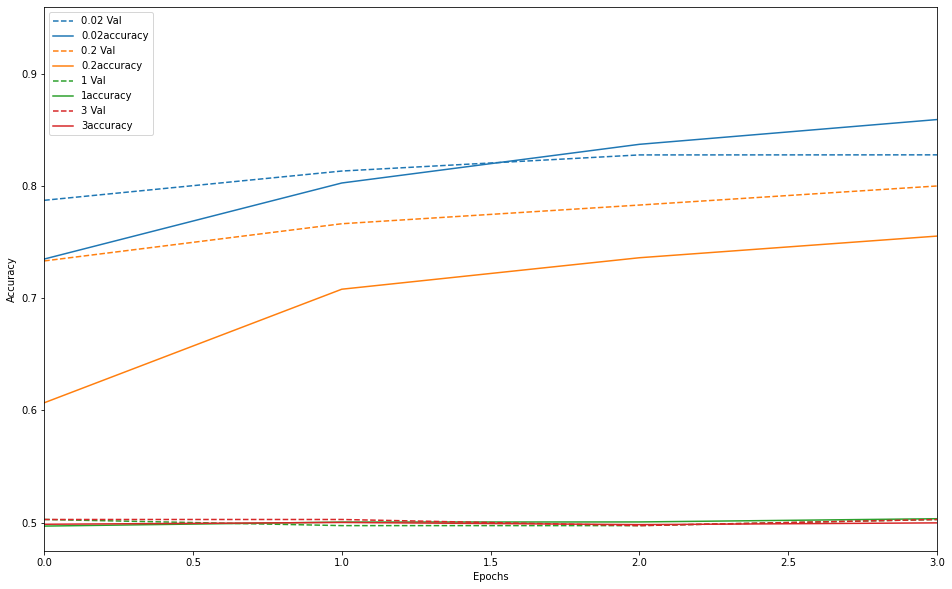

In [35]:
plot_history([('0.02', max_len_fifty_history),
              ('0.2', l2_0_2_history),
              ('1', l2_1_history),
              ('3', l2_3_history)])

# 필터값 변경

## filter = 3, 4, 5, 6, 7

In [36]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5,6,7]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
filter_5_model = tf.keras.Model(sequence_input, output)
filter_5_model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 300)      14157600    input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 50, 128)      115328      embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 50, 128)      153728      embedding_7[0][0]                
______________________________________________________________________________________

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

filter_5_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filter_5_history = filter_5_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 130s 35ms/step - loss: 0.5617 - accuracy: 0.7868 - val_loss: 0.5559 - val_accuracy: 0.8019
Epoch 2/10
3750/3750 [==============================] - 134s 36ms/step - loss: 0.5429 - accuracy: 0.8233 - val_loss: 0.5618 - val_accuracy: 0.8131
Epoch 3/10
3750/3750 [==============================] - 134s 36ms/step - loss: 0.5257 - accuracy: 0.8517 - val_loss: 0.5654 - val_accuracy: 0.8202
Epoch 4/10
3750/3750 [==============================] - 139s 37ms/step - loss: 0.5072 - accuracy: 0.8762 - val_loss: 0.6137 - val_accuracy: 0.8207
Epoch 5/10
3750/3750 [==============================] - 139s 37ms/step - loss: 0.4857 - accuracy: 0.8986 - val_loss: 0.6563 - val_accuracy: 0.8223
Epoch 6/10
3750/3750 [==============================] - 135s 36ms/step - loss: 0.4639 - accuracy: 0.9174 - val_loss: 0.6543 - val_accuracy: 0.8112
Epoch 7/10
3750/3750 [==============================] - 136s 36ms/step - loss: 0.4427 - accuracy: 0.9314 - val_loss: 0

## filter = 3, 5, 7

In [41]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,5,7]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
filter_357_model = tf.keras.Model(sequence_input, output)
filter_357_model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 50, 300)      14157600    input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 50, 128)      115328      embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 50, 128)      192128      embedding_9[0][0]                
______________________________________________________________________________________

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

filter_357_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filter_357_history = filter_357_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 88s 23ms/step - loss: 0.5972 - accuracy: 0.7263 - val_loss: 0.5213 - val_accuracy: 0.7888
Epoch 2/10
3750/3750 [==============================] - 89s 24ms/step - loss: 0.5220 - accuracy: 0.8020 - val_loss: 0.5036 - val_accuracy: 0.8105
Epoch 3/10
3750/3750 [==============================] - 87s 23ms/step - loss: 0.4909 - accuracy: 0.8334 - val_loss: 0.5531 - val_accuracy: 0.8008
Epoch 4/10
3750/3750 [==============================] - 95s 25ms/step - loss: 0.4687 - accuracy: 0.8581 - val_loss: 0.5159 - val_accuracy: 0.8231
Epoch 5/10
3750/3750 [==============================] - 88s 23ms/step - loss: 0.4417 - accuracy: 0.8828 - val_loss: 0.5489 - val_accuracy: 0.8276
Epoch 6/10
3750/3750 [==============================] - 85s 23ms/step - loss: 0.4172 - accuracy: 0.9017 - val_loss: 0.5993 - val_accuracy: 0.8224
Epoch 7/10
3750/3750 [==============================] - 86s 23ms/step - loss: 0.3919 - accuracy: 0.9193 - val_loss: 0.6293 -

## filter = 1, 2, 3

In [44]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [1,2,3]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
filter_123_model = tf.keras.Model(sequence_input, output)
filter_123_model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 50, 300)      14157600    input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 50, 128)      38528       embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 50, 128)      76928       embedding_10[0][0]               
______________________________________________________________________________________

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

filter_123_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filter_123_history = filter_123_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 54s 14ms/step - loss: 0.5987 - accuracy: 0.7392 - val_loss: 0.5433 - val_accuracy: 0.7974
Epoch 2/10
3750/3750 [==============================] - 56s 15ms/step - loss: 0.5256 - accuracy: 0.8065 - val_loss: 0.5271 - val_accuracy: 0.8186
Epoch 3/10
3750/3750 [==============================] - 55s 15ms/step - loss: 0.5065 - accuracy: 0.8290 - val_loss: 0.5072 - val_accuracy: 0.8249
Epoch 4/10
3750/3750 [==============================] - 56s 15ms/step - loss: 0.4910 - accuracy: 0.8464 - val_loss: 0.5086 - val_accuracy: 0.8333
Epoch 5/10
3750/3750 [==============================] - 56s 15ms/step - loss: 0.4790 - accuracy: 0.8593 - val_loss: 0.5227 - val_accuracy: 0.8333
Epoch 6/10
3750/3750 [==============================] - 57s 15ms/step - loss: 0.4682 - accuracy: 0.8724 - val_loss: 0.5330 - val_accuracy: 0.8360
Epoch 7/10
3750/3750 [==============================] - 56s 15ms/step - loss: 0.4558 - accuracy: 0.8840 - val_loss: 0.5667 -

## filter = 4, 5, 6

In [46]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [4,5,6]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
filter_456_model = tf.keras.Model(sequence_input, output)
filter_456_model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 50, 300)      14157600    input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 50, 128)      153728      embedding_11[0][0]               
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 50, 128)      192128      embedding_11[0][0]               
______________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

filter_456_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filter_456_history = filter_456_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 83s 22ms/step - loss: 0.5997 - accuracy: 0.7204 - val_loss: 0.5207 - val_accuracy: 0.7829
Epoch 2/10
3660/3750 [============================>.] - ETA: 1s - loss: 0.5184 - accuracy: 0.7994

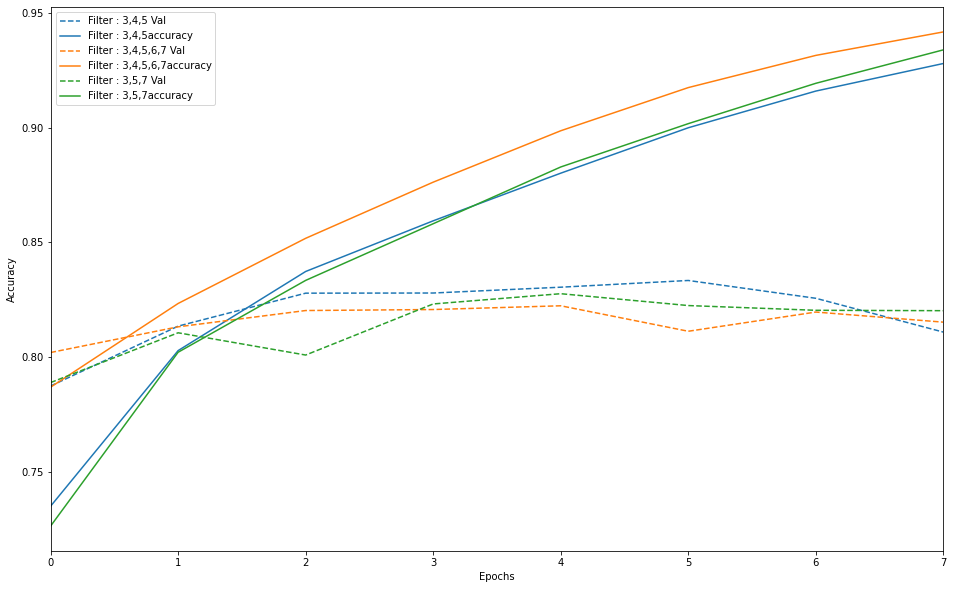

In [43]:
plot_history([('filter : 3,4,5', max_len_fifty_history),
              ('filter : 3,4,5,6,7', filter_5_history),
              ('filter : 3,5,7', filter_357_history),
              ('filter : 1,2,3', filter_123_history),
              ('filter : 4,5,6', filter_456_history),
             ])

# 예측

In [132]:
clean_doc[10:20]

['걍 인피니트 짱 진짜 짱 ♥',
 '볼때 눈물나다 죽다 90년 대의 향수 자극 허진호 감성 절제 멜로 달인',
 '울면 손 횡단보도 건너다 뛰다 치다 올 뻔 이범수 연기 드럽다 못 하다',
 '담백하다 깔끔하다 좋다 신 문 기 사 로만 보다 보다 자꾸 잊어버리다 이다',
 '취향 존중 다지 진짜 내생 극장 보다 영화 중 가장 노잼 노 감동 임 스토리 어거지 감동 어거지',
 'ㄱ 냥 매번 긴장 되다 재밋음 ㅠㅠ',
 '차다 웃기다 바스코 이기 락스 코 끄다 바비 이기 아이돌 깔다 그냥 끄다 안달 보이다',
 '굿바이 레닌 표절 이해 하다 왜 뒤 갈수록 재미 없어지다',
 '이건 정말 깨알 캐스팅 질퍽 않다 산뜻하다 내 용구성 자다 버무러진 깨알 일드 ♥',
 '약탈 자 위 변명 이르다 저 놈 착하다 놈 절대 아니다 걸']

In [139]:
sentence = ['짱', '존나', '재미', 'ㅋㅋㅋㅋ', doc[4]]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_len, padding = 'post', truncating= 'post')
print(model.predict(padded_exp).round(2))

[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]


# 데이터 저장과 불러오기

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

new_model = tf.keras.models.load_model('saved_model/my_model')